In [17]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random as ra
import math

from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

In [2]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1 #binary for whether it is digit or not
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [3]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [6]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [7]:
file_pth = 'binary_ffn_3.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained
trained_dig = int(file_pth[-5])

In [10]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        mask = (labels == trained_dig)
        if not mask.any():
            continue
        images = images[mask]
        if CUDA:
            images = images.cuda()
        images = images.view(-1, 28*28)

        a0 = F.tanh(net.fc0(images))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)
        predicted = (torch.sigmoid(logits) >= 0.5).float()

        correct += predicted.sum().item()
        total += images.size(0)

    print(f'Accuracy on digit {trained_dig} (manual pass with activations): {100 * correct / total:.2f} %')


Accuracy on digit 3 (manual pass with activations): 99.31 %


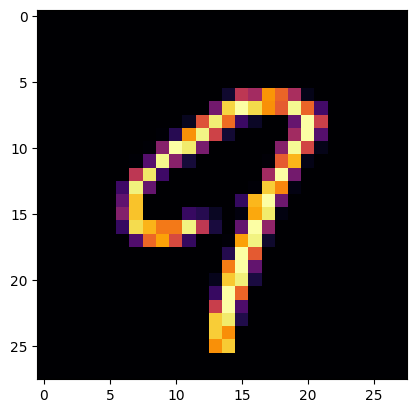

In [67]:
inputs, labels = next(iter(test_loader))
dig_to_check = 9

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break

plt.imshow(img, cmap="inferno")


In [85]:
pixel_count_important = (img > 0).sum().item()
segment_size = round(pixel_count_important * 0.04, 0)

imp_pixels = (img > 0.5).nonzero(as_tuple=False) #tensor of coordiantes that aren't = 0 (just which pixels are to be clustered)

pixel_count_important, segment_size


(153, 6.0)

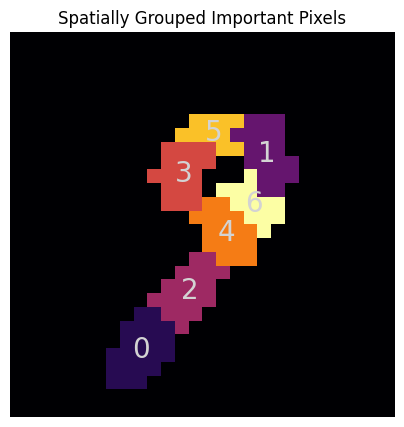

In [86]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=segment_size,
    linkage='complete',
    metric='euclidean'
)
labels = clusterer.fit_predict(imp_pixels) #apply clusterer to img

clusters = defaultdict(list)
for coord, label in zip(imp_pixels, labels):
    clusters[label].append(coord) #data structure to assign label to each group of pixles

#making a map
label_map = torch.zeros((28, 28), dtype=torch.int32)
for label, coords in clusters.items():
    for y, x in coords:
        label_map[y, x] = label + 1

label_map_np = label_map.numpy()
unique_vals = np.unique(label_map_np)

plt.figure(figsize=(5, 5))
plt.imshow(label_map_np, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Spatially Grouped Important Pixels')

for val in unique_vals:
    positions = np.argwhere(label_map_np == val)
    if positions.size == 0 or val == 0:
        continue
    centroid = positions.mean(axis=0)
    y, x = centroid
    plt.text(x, y, str(val-1), color='lightgray', fontsize=20, ha='center', va='center')

plt.show()


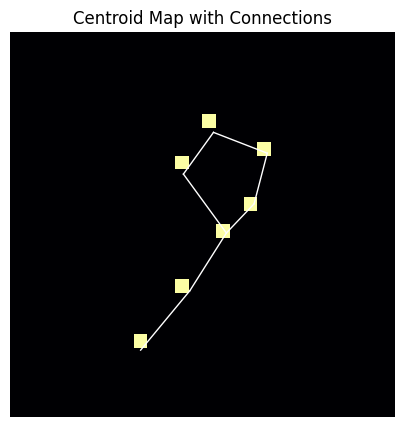

In [94]:
from scipy.ndimage import binary_dilation

#centroids
centroids = {}
for label, coords in clusters.items():
    centroids[label] = np.mean(coords, axis=0)  #(y,x) because np, matplot etc... order by row then column -> y then x

#touch detection
structure = np.ones((3,3), dtype=bool) #bin dilation checks for all 8 connected neighbors, therefore 3x3
touching = set()
for l1, c1 in clusters.items():
    mask = np.zeros((28,28), dtype=bool)
    for y,x in c1: mask[y,x]=1
    dil = binary_dilation(mask, structure=structure)
    for l2, c2 in clusters.items():
        if l1>=l2: continue
        if any(dil[y,x] for y,x in c2): touching.add((l1,l2)) #which labels touch

#centroid map
centroid_map = torch.zeros((28,28), dtype=torch.float32)
for l, (y,x) in centroids.items():
    centroid_map[int(y), int(x)] = 1

#plot map
plt.figure(figsize=(5,5))
plt.imshow(centroid_map, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Centroid Map with Connections')

#draw lines
for l1,l2 in touching:
    y1,x1 = centroids[l1]
    y2,x2 = centroids[l2]
    plt.plot([x1,x2], [y1,y2], color='white', linewidth=1)


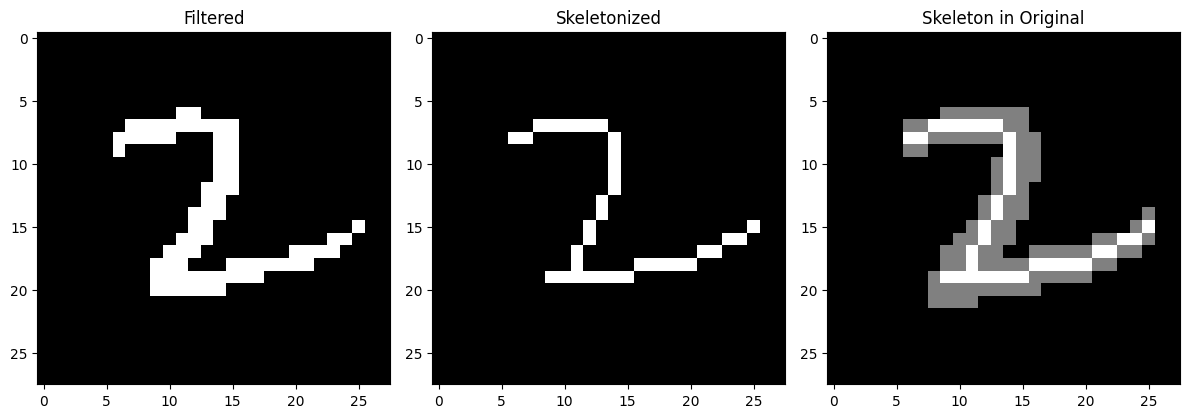

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize


inputs, labels = next(iter(test_loader))
dig_to_check = ra.randint(0, 9)

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break


img_np = img.cpu().numpy()
filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

skeleton = skeletonize(filtered)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Filtered")
plt.imshow(filtered, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Skeletonized")
plt.imshow(skeleton, cmap='gray')

#is this better than the other method??? update: yeah it actually is, screw the other one


actual = torch.where(
    img == 0,
    torch.tensor(0.0, device=img.device),
    0.5
)

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    actual[y, x] = 1

plt.subplot(1, 3, 3)
plt.title("Skeleton in Original")
plt.imshow(actual, cmap="gray")

plt.tight_layout()
plt.show()

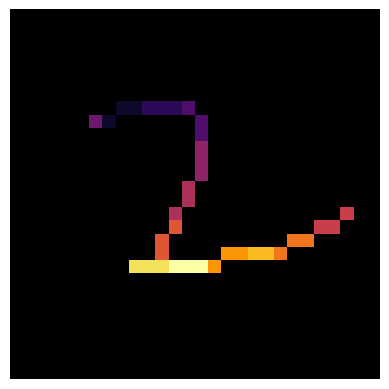

In [220]:
used = set()
groups = []
pixels = set(zip(y_true, x_true))

for y, x in zip(y_true, x_true):
    if (y, x) in used:
        continue
    
    group = [(y, x)]
    used.add((y, x))
    
    for ny, nx in [(y+i, x+j) for i in [-1,0,1] for j in [-1,0,1]]: #check all 8 neighbors
        if (ny, nx) not in used and 0 <= ny < 28 and 0 <= nx < 28 and (ny, nx) in pixels:
            group.append((ny, nx))
            used.add((ny, nx))
    
    if len(group) < 3:
        for ny, nx in [(y+i, x+j) for i in range(-2,3) for j in range(-2,3)]: #checking 14 neighbors in next outer layer
            if len(group) >= 3: #try exactly 3
                break
            if (ny, nx) not in used and 0 <= ny < 28 and 0 <= nx < 28 and (ny, nx) in pixels:
                group.append((ny, nx))
                used.add((ny, nx))
    
    groups.append(group)

color_map = np.zeros((28, 28))
for n, group in enumerate(groups):
    for y, x in group:
        color_map[y, x] = n + 1

plt.imshow(color_map, cmap='inferno')
plt.axis('off')
plt.show()


In [209]:
#don't forget to add lines later for cleaner visualisation!

In [221]:
#now find concepts of cluster combinations that optimally activate the FFN final predcition probability distributions!